In [1]:
import numpy as np

# Percorsi ai file
X = np.load("dataset_75/images.npy")
y = np.load("dataset_75/labels.npy")

X = X.astype("float32") / 255.0

X = X[..., np.newaxis]

print(X.shape)  # es. (18000, 150, 150) o (18000, 75, 75)
print(y.shape)  # es. (18000, 2)



(18000, 75, 75, 1)
(18000, 2)


In [2]:
label_range=5 #minutes the are togheter in the same class
number_of_classifiers=60//label_range

label=y.copy()
label[:,1]=label[:,1]//label_range

print(label[17999])
print(y[17999])
print(number_of_classifiers)

[11 11]
[11 59]
12


In [3]:
from sklearn.model_selection import train_test_split

X_traina, X_test, y_traina, y_test = train_test_split(X, label, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True)

print(y_test.shape)
print(y_val.shape)
print(y_train.shape)
print(y_train[0].shape)

(1800, 2)
(1800, 2)
(14400, 2)
(2,)


In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers, models, regularizers
from keras.optimizers import AdamW
from keras.callbacks import ReduceLROnPlateau


2025-10-25 18:56:51.908489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 18:56:51.941675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 18:56:56.368641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
model_body = keras.Sequential([
    keras.layers.Conv2D(32, (5,5), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),    

    keras.layers.GlobalAveragePooling2D()
])

hours_head=keras.Sequential([
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(12, activation="softmax")],name="hours")

hours_minutes=keras.Sequential([
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(number_of_classifiers, activation="softmax")],name="minutes")


input=keras.Input(shape=X[0].shape)
x=model_body(input)
out_hours=hours_head(x)
out_minutes=hours_minutes(x)

model=keras.Model(inputs=input, outputs=[out_hours,out_minutes])



I0000 00:00:1761411421.593447  865059 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6152 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
model.compile(
    optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
    loss={"hours":"sparse_categorical_crossentropy", "minutes":"sparse_categorical_crossentropy"},
    loss_weights={"hours":number_of_classifiers,"minutes":1},
    metrics={
        "hours": ["accuracy"],
        "minutes": ["accuracy"]}
)

In [7]:
# Reduce LR when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True
)

early_stopping=keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [8]:
history_base = model.fit(
    X_train, [y_train[:,0],y_train[:,1]],
    epochs=100,
    batch_size=64,
    validation_data=(X_val, [y_val[:,0],y_val[:,1]]),
    callbacks=[lr_scheduler,checkpoint,early_stopping]
)


Epoch 1/100


2025-10-25 18:57:11.309420: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c3c4c006920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-25 18:57:11.309436: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-10-25 18:57:11.346570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-25 18:57:11.565054: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-25 18:57:11.675870: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-25 18:57:11.675892: I e

 15/225 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - hours_accuracy: 0.0963 - hours_loss: 2.5310 - loss: 32.9419 - minutes_accuracy: 0.0766 - minutes_loss: 2.5352

I0000 00:00:1761411435.057037  865222 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - hours_accuracy: 0.1195 - hours_loss: 2.4323 - loss: 31.6483 - minutes_accuracy: 0.1164 - minutes_loss: 2.4265 - val_hours_accuracy: 0.0789 - val_hours_loss: 4.5251 - val_loss: 59.0182 - val_minutes_accuracy: 0.0806 - val_minutes_loss: 4.7387 - learning_rate: 5.0000e-04
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - hours_accuracy: 0.1961 - hours_loss: 2.1684 - loss: 28.2846 - minutes_accuracy: 0.1700 - minutes_loss: 2.2294 - val_hours_accuracy: 0.0861 - val_hours_loss: 5.5915 - val_loss: 73.0562 - val_minutes_accuracy: 0.0856 - val_minutes_loss: 5.8427 - learning_rate: 5.0000e-04
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - hours_accuracy: 0.3335 - hours_loss: 1.7578 - loss: 23.2304 - minutes_accuracy: 0.2092 - minutes_loss: 2.1012 - val_hours_accuracy: 0.0922 - val_hours_loss: 3.6828 - val_loss: 48.6343 - val_minutes_accuracy: 0.0878 - val_minutes_loss: 4.4898 - learning_rate: 5.0000e-04
Epoch 4/100
225/225 ━━━━━━━━━━━━━━

In [10]:
# Carichiamo il modello salvato con i pesi migliori
best = keras.models.load_model("best_model.keras")

# Prepara le etichette
y_train_hours = keras.utils.to_categorical(y_train[:, 0], num_classes=12)
y_train_minutes = keras.utils.to_categorical(y_train[:, 1], num_classes=number_of_classifiers)

y_test_hours = keras.utils.to_categorical(y_test[:, 0], num_classes=12)
y_test_minutes = keras.utils.to_categorical(y_test[:, 1], num_classes=number_of_classifiers)

results_train = best.evaluate(
    X_train, {"hours": y_train[:, 0], "minutes": y_train[:, 1]}, verbose=0
)

results_test = best.evaluate(
    X_test, {"hours": y_test[:, 0], "minutes": y_test[:, 1]}, verbose=0
)


print("\n📊 Risultati sul TRAIN set:")
for name, value in zip(best.metrics_names, results_train):
    print(f"{name}: {value:.4f}")


print("\n📊 Risultati sul TEST set:")
for name, value in zip(best.metrics_names, results_test):
    print(f"{name}: {value:.4f}")



📊 Risultati sul TRAIN set:
loss: 0.1345
compile_metrics: 0.0004
hours_loss: 0.0497
minutes_loss: 1.0000

📊 Risultati sul TEST set:
loss: 0.9655
compile_metrics: 0.0543
hours_loss: 0.2336
minutes_loss: 0.9833


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 Accuracy ore: 0.9833
 Accuracy minuti: 0.9017
 Accuracy media complessiva: 0.9425
Confusion matrix - ORE

Confusion matrix - MINUTI


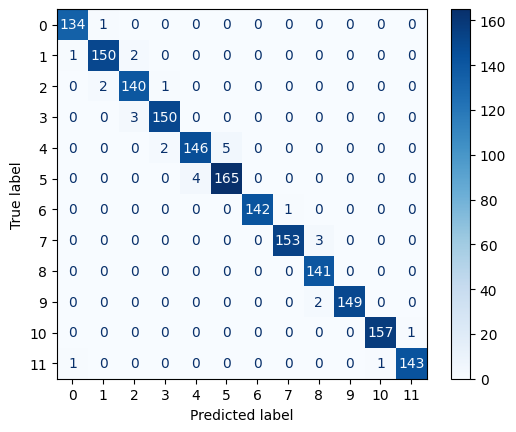

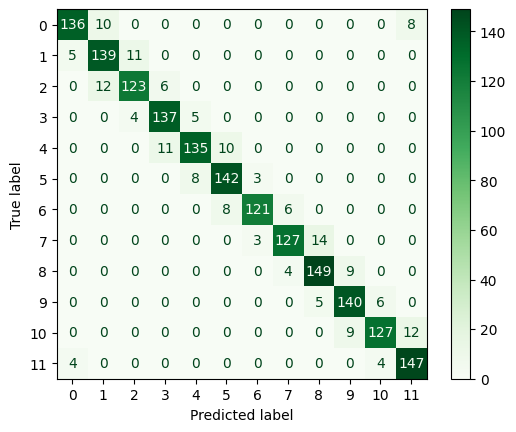

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Predizioni del modello
y_pred_hours, y_pred_minutes = best.predict(X_test)

# Conversione in classi (argmax su ogni testa)
y_pred_hours_classes = np.argmax(y_pred_hours, axis=1)
y_pred_minutes_classes = np.argmax(y_pred_minutes, axis=1)

# Matrici di confusione
cm_hours = confusion_matrix(y_test[:, 0], y_pred_hours_classes)
cm_minutes = confusion_matrix(y_test[:, 1], y_pred_minutes_classes)

# Accuratezze
acc_hours = accuracy_score(y_test[:, 0], y_pred_hours_classes)
acc_minutes = accuracy_score(y_test[:, 1], y_pred_minutes_classes)
acc_mean = (acc_hours + acc_minutes) / 2

print(f" Accuracy ore: {acc_hours:.4f}")
print(f" Accuracy minuti: {acc_minutes:.4f}")
print(f" Accuracy media complessiva: {acc_mean:.4f}")

# Visualizzazione
print("Confusion matrix - ORE")
ConfusionMatrixDisplay(cm_hours).plot(cmap="Blues")

print("\nConfusion matrix - MINUTI")
ConfusionMatrixDisplay(cm_minutes).plot(cmap="Greens")



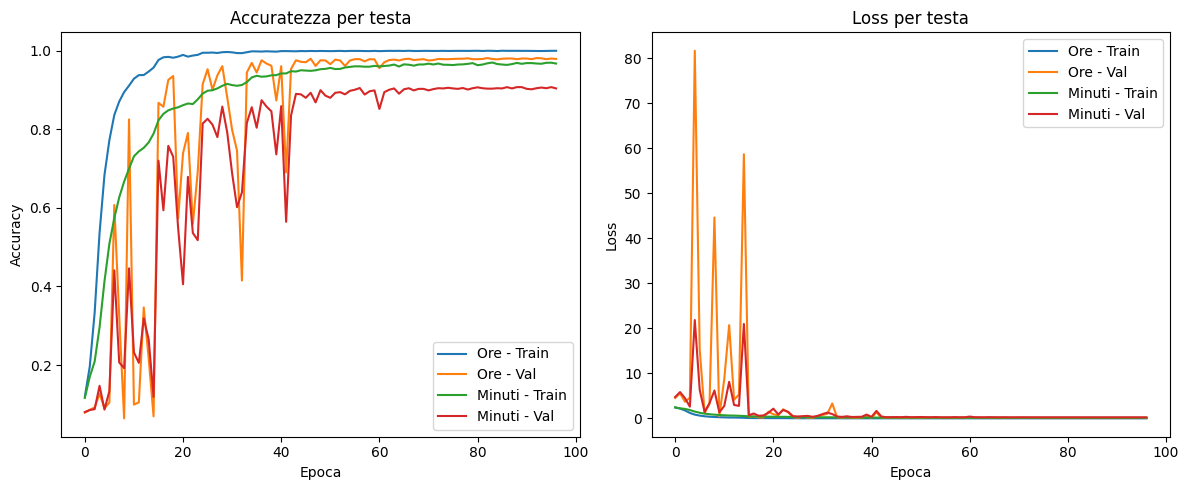

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# --- Accuracy ---
plt.subplot(1,2,1)
plt.plot(history_base.history["hours_accuracy"], label="Ore - Train")
plt.plot(history_base.history["val_hours_accuracy"], label="Ore - Val")
plt.plot(history_base.history["minutes_accuracy"], label="Minuti - Train")
plt.plot(history_base.history["val_minutes_accuracy"], label="Minuti - Val")
plt.title("Accuratezza per testa")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()

# --- Loss ---
plt.subplot(1,2,2)
plt.plot(history_base.history["hours_loss"], label="Ore - Train")
plt.plot(history_base.history["val_hours_loss"], label="Ore - Val")
plt.plot(history_base.history["minutes_loss"], label="Minuti - Train")
plt.plot(history_base.history["val_minutes_loss"], label="Minuti - Val")
plt.title("Loss per testa")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


: 

: 

: 